✅ Loaded Gold Table: (12500, 71)
  customer_id   age  occ_accountant  occ_architect  occ_developer  occ_doctor  \
0  CUS_0x1000  18.0               0              0              0           0   
1  CUS_0x1009  26.0               0              0              0           0   
2  CUS_0x100b  19.0               0              0              0           0   

   occ_engineer  occ_entrepreneur  occ_journalist  occ_lawyer  ...  fe_12  \
0             0                 0               0           1  ...  109.5   
1             0                 0               0           0  ...  109.5   
2             0                 0               0           0  ...  109.5   

   fe_13  fe_14  fe_15  fe_16  fe_17  fe_18  fe_19  fe_20  default_flag  
0  102.0   93.0   95.5  100.0  100.0  107.5   99.5   93.0             1  
1  102.0   93.0   95.5  100.0  100.0  107.5   99.5   93.0             0  
2  102.0   93.0   95.5  100.0  100.0  107.5   99.5   93.0             0  

[3 rows x 71 columns]

🎯 Target vari

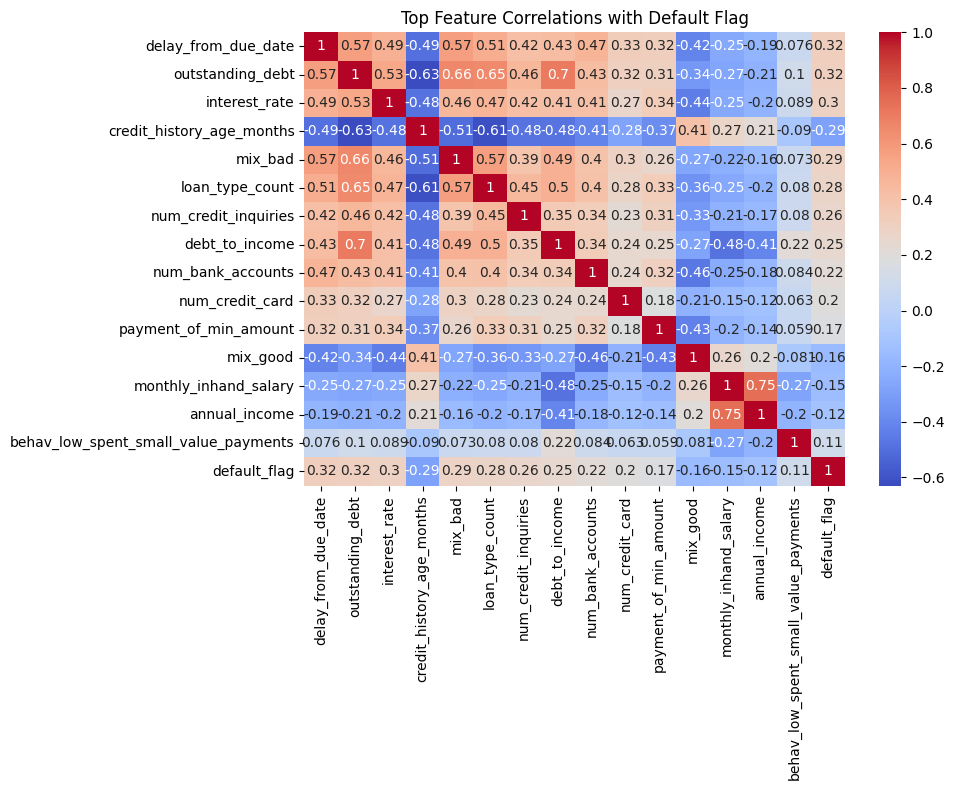


⚠️ Highly skewed features (|skew| > 2):
delayed_payment_rate                      24.760206
num_of_loan                               15.846910
num_of_delayed_payment                    13.324113
emi_to_income_ratio                       11.696350
total_emi_per_month                        5.297395
amount_invested_monthly                    4.345583
occ_writer                                 3.773008
occ_manager                                3.748284
occ_musician                               3.733022
occ_doctor                                 3.676323
occ_journalist                             3.673394
occ_entrepreneur                           3.630096
occ_mechanic                               3.618748
occ_media_manager                          3.618748
occ_developer                              3.618748
occ_teacher                                3.613104
occ_scientist                              3.593510
occ_accountant                             3.587956
occ_engineer           

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the final Gold feature store ---
df = pd.read_csv("datamart/gold/feature_store.csv")

print("✅ Loaded Gold Table:", df.shape)
print(df.head(3))

# --- Check target distribution ---
target_col = "default_flag"
print("\n🎯 Target variable distribution:")
print(df[target_col].value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

# --- Check nulls ---
nulls = df.isnull().sum()
if nulls.sum() == 0:
    print("\n✅ No nulls detected.")
else:
    print("\n⚠️ Null counts:\n", nulls[nulls > 0])

# --- Drop ID/time columns (non-predictive) ---
drop_cols = [c for c in df.columns if "customer_id" in c or "snapshot_date" in c]
X = df.drop(columns=drop_cols + [target_col])
y = df[target_col]

print(f"\n📦 Features for modeling: {X.shape[1]} columns")

# --- Detect constant or near-constant columns ---
const_cols = [c for c in X.columns if X[c].nunique() <= 1]
if const_cols:
    print("⚠️ Constant columns found:", const_cols)
    X = X.drop(columns=const_cols)

# --- Check correlations with target ---
corrs = {}
for col in X.select_dtypes(include=[np.number]).columns:
    corrs[col] = np.corrcoef(X[col], y)[0, 1]
corr_df = pd.Series(corrs).abs().sort_values(ascending=False)
print("\n🔍 Top correlated features with default_flag:")
print(corr_df.head(10))

# --- Plot heatmap of top correlated features ---
top_corr = corr_df.head(15).index
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr.to_list() + [target_col]].corr(), annot=True, cmap="coolwarm")
plt.title("Top Feature Correlations with Default Flag")
plt.tight_layout()
plt.show()

# --- Skewness check (optional) ---
skew_vals = X.skew().sort_values(ascending=False)
high_skew = skew_vals[abs(skew_vals) > 2]
if len(high_skew) > 0:
    print("\n⚠️ Highly skewed features (|skew| > 2):")
    print(high_skew)
else:
    print("\n✅ No severe skew detected.")

# --- Save clean data ready for modeling ---
X.to_csv("datamart/gold/X_features.csv", index=False)
y.to_csv("datamart/gold/y_target.csv", index=False)
print("\n📂 Saved cleaned X and y for modeling.")


Train shape: (10000, 69), Test shape: (2500, 69)

✅ Model Performance:
Accuracy: 0.790
Precision: 0.666
Recall: 0.542
F1-score: 0.597
ROC-AUC: 0.815



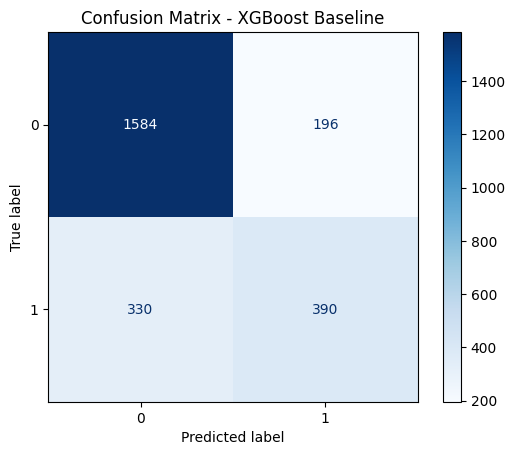

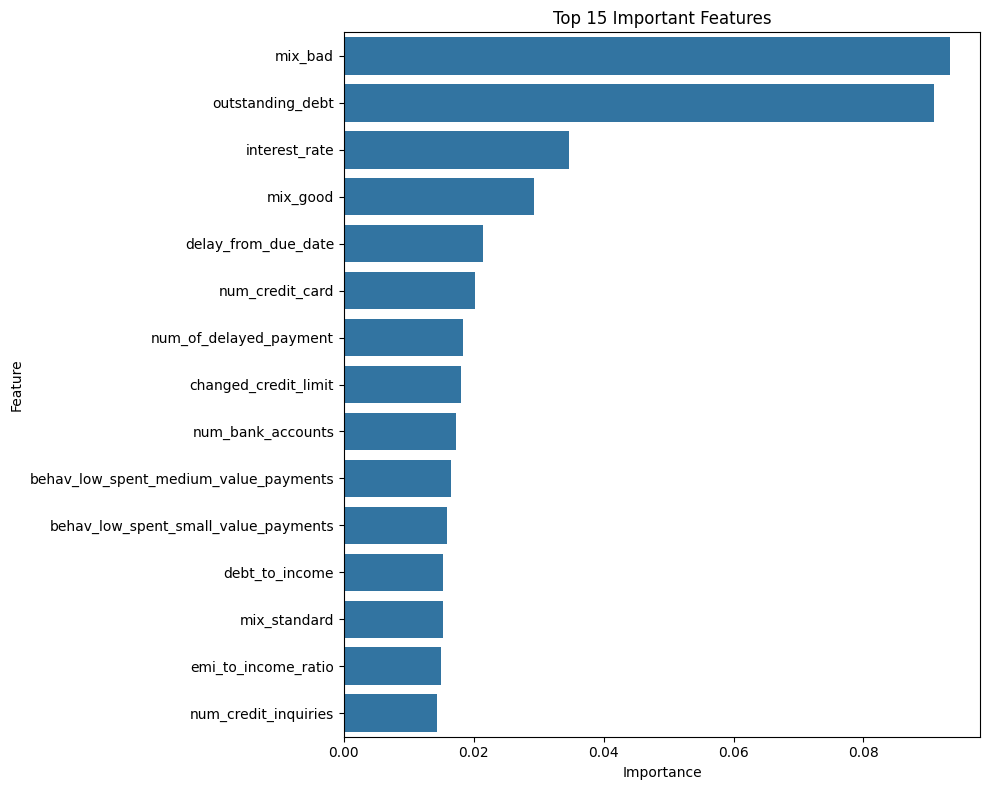

💾 Model saved to model_store/xgb_baseline.pkl


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import joblib
import os

# --- Load prepared features ---
X = pd.read_csv("datamart/gold/X_features.csv")
y = pd.read_csv("datamart/gold/y_target.csv").squeeze()

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- Train baseline XGBoost model ---
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="auc"
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# --- Evaluate performance ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"""
✅ Model Performance:
Accuracy: {acc:.3f}
Precision: {prec:.3f}
Recall: {rec:.3f}
F1-score: {f1:.3f}
ROC-AUC: {auc:.3f}
""")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost Baseline")
plt.show()

# --- Feature Importance ---
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance.head(15), x="Importance", y="Feature")
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()

# --- Save model ---
os.makedirs("model_store", exist_ok=True)
joblib.dump(model, "model_store/xgb_baseline.pkl")
print("💾 Model saved to model_store/xgb_baseline.pkl")


In [1]:
import pandas as pd

# Load temporal Gold table
df = pd.read_csv("datamart/gold/feature_store.csv")

# Convert date column
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")

# Basic info
print("📦 Shape:", df.shape)
print("🗓️ Date range:", df["snapshot_date"].min(), "→", df["snapshot_date"].max())
print("🧍 Unique customers:", df["customer_id"].nunique())
print("📅 Unique snapshot months:", df["snapshot_date"].dt.to_period("M").nunique())


📦 Shape: (12500, 72)
🗓️ Date range: 2023-01-01 00:00:00 → 2025-01-01 00:00:00
🧍 Unique customers: 12500
📅 Unique snapshot months: 25


In [2]:
df["month"] = df["snapshot_date"].dt.to_period("M")
monthly_counts = df.groupby("month")["customer_id"].nunique()
print(monthly_counts.sort_index())


month
2023-01    530
2023-02    501
2023-03    506
2023-04    510
2023-05    521
2023-06    517
2023-07    471
2023-08    481
2023-09    454
2023-10    487
2023-11    491
2023-12    489
2024-01    485
2024-02    518
2024-03    511
2024-04    513
2024-05    491
2024-06    498
2024-07    505
2024-08    543
2024-09    493
2024-10    456
2024-11    488
2024-12    515
2025-01    526
Freq: M, Name: customer_id, dtype: int64


In [3]:
if "default_flag" in df.columns:
    monthly_defaults = df.groupby("month")["default_flag"].mean()
    print("\n📊 Default rate over time (%):")
    print((monthly_defaults * 100).round(2))
else:
    print("⚠️ No 'default_flag' column found.")



📊 Default rate over time (%):
month
2023-01    26.42
2023-02    30.74
2023-03    32.02
2023-04    26.86
2023-05    26.68
2023-06    26.50
2023-07    29.72
2023-08    28.90
2023-09    26.21
2023-10    25.67
2023-11    29.12
2023-12    30.88
2024-01    29.69
2024-02    28.38
2024-03    32.88
2024-04    27.68
2024-05    30.35
2024-06    31.12
2024-07    30.69
2024-08    30.02
2024-09    33.06
2024-10    24.56
2024-11    28.07
2024-12    27.18
2025-01    26.81
Freq: M, Name: default_flag, dtype: float64


In [4]:
missing_summary = df.isnull().mean().sort_values(ascending=False)
print("🔍 Missingness summary (top 10):\n", missing_summary.head(10))


🔍 Missingness summary (top 10):
 customer_id             0.0
mix_good                0.0
fe_3                    0.0
fe_2                    0.0
fe_1                    0.0
delayed_payment_rate    0.0
debt_to_income          0.0
emi_to_income_ratio     0.0
loan_type_count         0.0
behav_unknown           0.0
dtype: float64
